## Analisis de Datos de Pinguinos

Mediciones de tamaño, observaciones de nidadas y proporciones de isótopos en la sangre de pingüinos Adelie, Chinstrap y Gentoo adultos en busca de alimento observados en islas del archipiélago Palmer cerca de la estación Palmer, en la Antártida. Los datos fueron recopilados y puestos a disposición por la Dra. Kristen Gorman y el Programa de Investigación Ecológica a Largo Plazo (LTER) de la Estación Palmer.

In [16]:
import empiricaldist
import janitor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.metrics
import statsmodels.formula.api as smf
import statsmodels.stats as ss

### Apariencia de los Graficos

In [17]:
#almacena los graficos en el notebooks
%matplotlib inline 
sns.set_style(style='whitegrid')
sns.set_context(context='notebook')
plt.rcParams['figure.figsize'] = (10, 8)

In [18]:
#Paleta de colores
penguin_color = {
    'Adelie': '#ff6602ff',
    'Gentoo': '#0f7175ff',
    'Chinstrap': '#c65dc9ff'
}

### 1. Cargar los Datos

In [19]:
preprocess_penguins_df = pd.read_csv('../data/penguins.csv')
preprocess_penguins_df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


### 2. Recoleccion y Validacion de los Datos

In [20]:
# Tipos de datos del dataset
preprocess_penguins_df.dtypes

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
year                   int64
dtype: object

Tenemos 4 variables de tipo float, 3 de tipo object y 1 de tipo int

In [21]:
# Cantidad de variables de cada tipo
(
    preprocess_penguins_df
    .dtypes
    .value_counts()
)

float64    4
object     3
int64      1
dtype: int64

In [22]:
# Cantidad de registros en el dataset
preprocess_penguins_df.shape

(344, 8)

In [23]:
# Variables que contienen valores nulos
(
    preprocess_penguins_df
    .isna()
    .any()
)

species              False
island               False
bill_length_mm        True
bill_depth_mm         True
flipper_length_mm     True
body_mass_g           True
sex                   True
year                 False
dtype: bool

In [24]:
# Cantidad de valores nulos por variable
(
    preprocess_penguins_df
    .isnull()
    .sum()
)

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

In [25]:
# Total de valores nulos en el dataset
(
    preprocess_penguins_df
    .isnull()
    .sum()
    .sum()
)

19

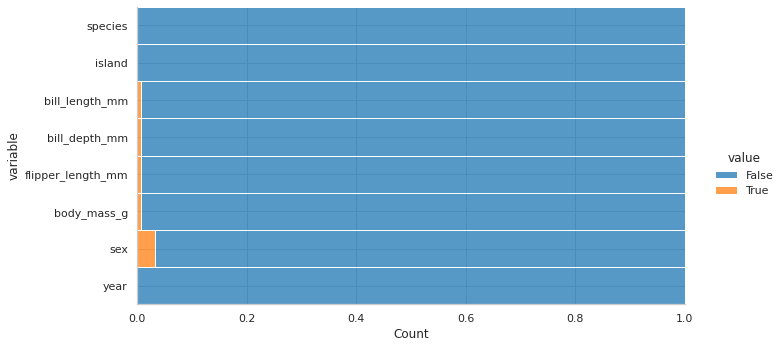

In [26]:
# Visualizacion de Proporcion de Valores nulos por cada variable
(
    preprocess_penguins_df
    .isnull()
    .melt()  # Convierte un df de formato ancho a formato largo
    .pipe(   # permite aplicar una o mas funciones al objeto df 
        lambda df:(
            sns.displot(
                data=df,
                y='variable',
                hue='value',
                multiple='fill',
                aspect=2 #ancho del grafica
            )
        )
    )
)
plt.show()

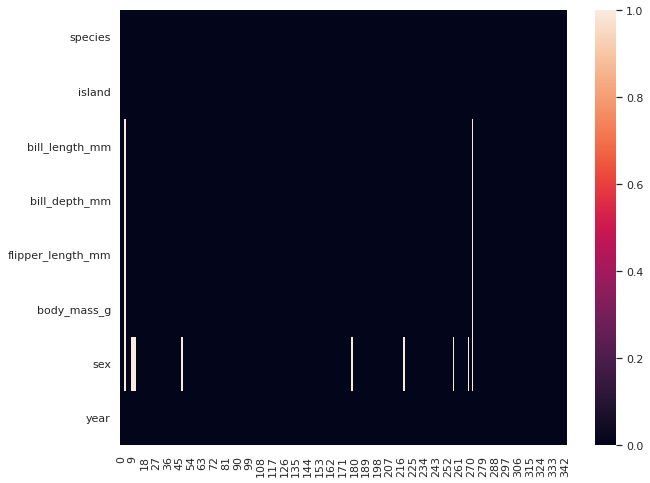

In [27]:
# Visualizacion de los valores nulos en todo el conjunto de datos
(
    preprocess_penguins_df
    .isnull()
    .transpose()
    .pipe(
        lambda df:(
            sns.heatmap(  #mapa de calor
                data=df
            )
        )
    )
)

plt.show()

In [28]:
# Cantidad de observaciones que se pierden si se eliminan los datos faltantes
preprocess_penguins_df = (
    preprocess_penguins_df
    .dropna()
)
preprocess_penguins_df.shape

(333, 8)

Se pierden 21 observaviones. No es una cantidad relevante que pueda influir en el analisis

### 3. Conteos y Proporciones

In [29]:
# Resumen estadistico de las variables numericas
preprocess_penguins_df.describe(include=[np.number])

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,333.000000,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057,2008.042042
std,5.468668,1.969235,14.015765,805.215802,0.812944
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.500000,15.600000,190.000000,3550.000000,2007.000000
50%,44.500000,17.300000,197.000000,4050.000000,2008.000000
75%,48.600000,18.700000,213.000000,4775.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


In [30]:
# Resumen estadistico de las variables categoricas
preprocess_penguins_df.describe(include=object)

,species,island,sex
count,333,333,333
unique,3,3,2
top,Adelie,Biscoe,male
freq,146,163,168


In [31]:
# Convertir las variables de tipo object en category
(
    preprocess_penguins_df
    .astype({
        'species':'category',
        'island':'category',
        'sex':'category'
    })
)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


#### 3.1 Visualizacion de los Conteos

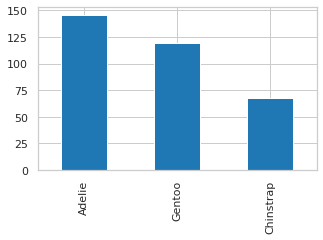

In [32]:
# Utilizando Pandas
# histograma de las Especies
(
    preprocess_penguins_df
    .species
    .value_counts()
    .plot(
        kind='bar',
        figsize=(5,3)
    )

)
plt.show()

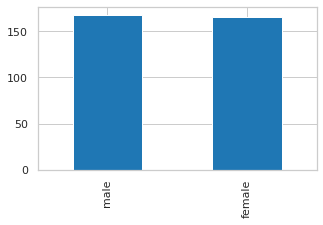

In [33]:
# Histograma del Sexo de los pinguinos
(
    preprocess_penguins_df
    .sex
    .value_counts()
    .plot(
        kind='bar',
        figsize=(5,3)
    )

)
plt.show()

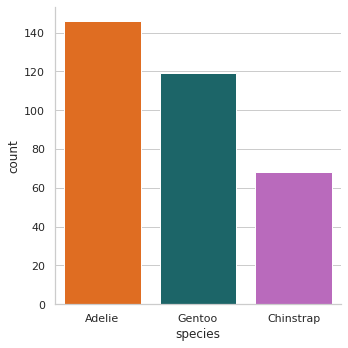

In [34]:
# Utilizando Seaborn
# histograma segun las Especies
sns.catplot(
    data=preprocess_penguins_df,
    x= 'species',
    kind= 'count',
    palette= penguin_color
)
plt.show()

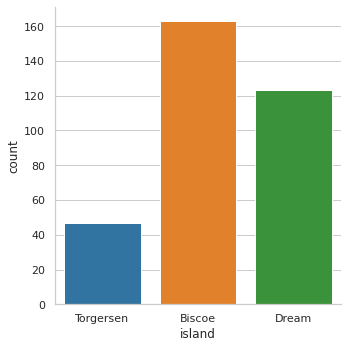

In [35]:
# Histograma de la cantidad de pinguinos segun la isla
sns.catplot(
    data=preprocess_penguins_df,
    x= 'island',
    kind= 'count',
    #palette= penguin_color
)
plt.show()

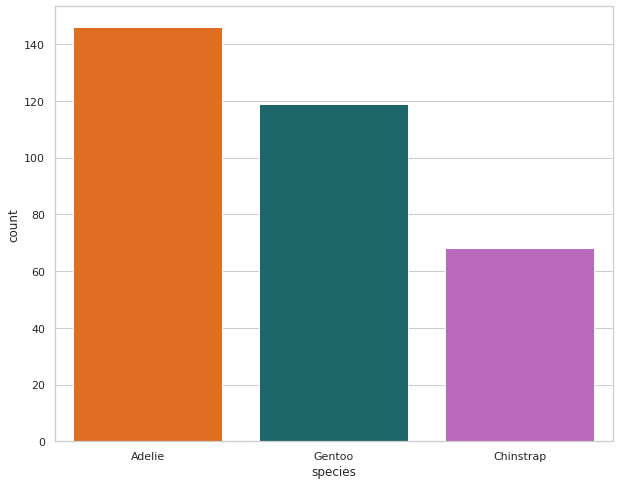

In [36]:
# Creando un Histograma directamente desde una tabla. Especies
(
    preprocess_penguins_df
    .value_counts('species', sort=True)
    .reset_index(name='count')
    .pipe(
        lambda df:(
            sns.barplot(
                data=df,
                x='species',
                y='count',
                palette=penguin_color
            )
        )
    )
)
plt.show()

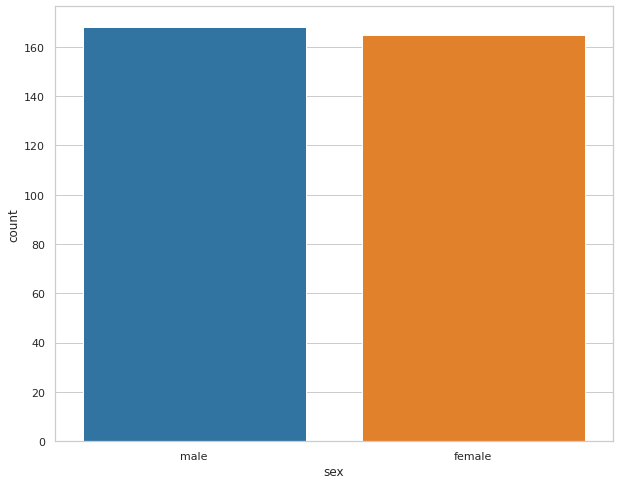

In [37]:
# Creando un Histograma directamente desde una tabla. Sexo

(
    preprocess_penguins_df
    .value_counts('sex', sort=True)
    .reset_index(name='count')
    .pipe(
        lambda df:(
            sns.barplot(
                data=df,
                x='sex',
                y='count',
                #palette=penguin_color
            )
        )
    )
)
plt.show()

#### 3.2 Visualizando Proporciones

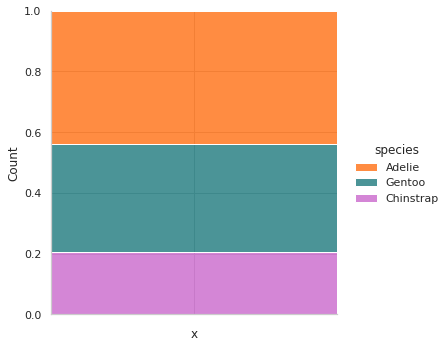

In [38]:
# Grafico de Proporciones
# Especies
(
    preprocess_penguins_df
    .add_column('x', '')
    .pipe(lambda df:(
        sns.displot(
            data=df,
            x='x',
            hue='species',
            multiple='fill',
            palette=penguin_color
        )
    )
    )
)
plt.show()

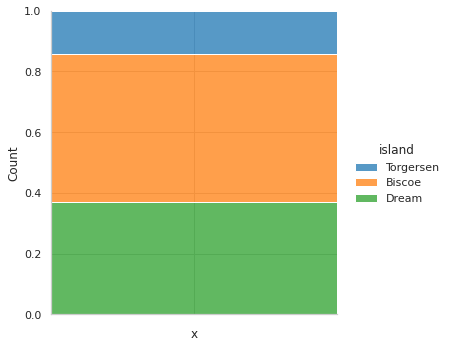

In [39]:
# Grafico de Proporciones
# isla
(
    preprocess_penguins_df
    .add_column('x', '')
    .pipe(lambda df:(
        sns.displot(
            data=df,
            x='x',
            hue='island',
            multiple='fill',
            #palette=penguin_color
        )
    )
    )
)
plt.show()

### 4. Medidas de Tendencia Central

#### 4.1 Media o Promedio

In [40]:
# Ancho promedio de los picos de los pinguinos 
# Pandas
preprocess_penguins_df.bill_depth_mm.mean()

17.164864864864867

In [41]:
# Promedio del largo de los picos de los pinguinos
# Numpy
np.mean(preprocess_penguins_df.bill_length_mm)

43.99279279279281

In [42]:
# Calculo del promedios de las variables numericas del dataset
preprocess_penguins_df.mean(numeric_only=True)

bill_length_mm         43.992793
bill_depth_mm          17.164865
flipper_length_mm     200.966967
body_mass_g          4207.057057
year                 2008.042042
dtype: float64

#### 4.2 Mediana

In [43]:
# Mediana de la longitud de las aletas
preprocess_penguins_df.flipper_length_mm.median()

197.0

In [44]:
# Mediana de todas las variables numericas del dataset
preprocess_penguins_df.median(numeric_only=True)

bill_length_mm         44.5
bill_depth_mm          17.3
flipper_length_mm     197.0
body_mass_g          4050.0
year                 2008.0
dtype: float64

#### 4.3 Moda

In [45]:
# Moda de todas las variables tanto categoricas como numericas
preprocess_penguins_df.mode()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Biscoe,41.1,17.0,190.0,3800.0,male,2009


### 5. Medidas de Dispersion

In [46]:
# Valores maximos de cada variable numerica de dataset
preprocess_penguins_df.max(numeric_only=True)

bill_length_mm         59.6
bill_depth_mm          21.5
flipper_length_mm     231.0
body_mass_g          6300.0
year                 2009.0
dtype: float64

In [47]:
# Valores minimos de cada variable numerica del dataset
preprocess_penguins_df.min(numeric_only=True)

bill_length_mm         32.1
bill_depth_mm          13.1
flipper_length_mm     172.0
body_mass_g          2700.0
year                 2007.0
dtype: float64

In [48]:
# Rango de las variables
preprocess_penguins_df.max(numeric_only=True) - preprocess_penguins_df.min(numeric_only=True)

bill_length_mm         27.5
bill_depth_mm           8.4
flipper_length_mm      59.0
body_mass_g          3600.0
year                    2.0
dtype: float64

In [49]:
# Desviacion Estandar del peso de los pinguino
preprocess_penguins_df.body_mass_g.std()

805.2158019428966

In [50]:
# Desviacion estandar de las variables numericas del dataset
preprocess_penguins_df.std(numeric_only=True)

bill_length_mm         5.468668
bill_depth_mm          1.969235
flipper_length_mm     14.015765
body_mass_g          805.215802
year                   0.812944
dtype: float64

#### 5.2 Rango que incluye el 65% de los Datos

In [51]:
# rango de la longitud del pico
rangeMin_bill_length = preprocess_penguins_df.bill_length_mm.mean() - preprocess_penguins_df.bill_length_mm.std()
rangeMax_bill_length = preprocess_penguins_df.bill_length_mm.mean() + preprocess_penguins_df.bill_length_mm.std()
print(f'({rangeMin_bill_length} , {rangeMax_bill_length})')

(38.52412445014525 , 49.46146113544037)


In [52]:
# rango del ancho del pico
rangeMin_bill_depth = preprocess_penguins_df.bill_depth_mm.mean() - preprocess_penguins_df.bill_depth_mm.std()
rangeMax_bill_depth = preprocess_penguins_df.bill_depth_mm.mean() + preprocess_penguins_df.bill_depth_mm.std()
print(f'({rangeMin_bill_depth} , {rangeMax_bill_depth})')

(15.195629401544966 , 19.13410032818477)


In [53]:
# rango de la longitud de las aletas
rangeMin_flipper_length = preprocess_penguins_df.flipper_length_mm.mean() - preprocess_penguins_df.flipper_length_mm.std()
rangeMax_flipper_length = preprocess_penguins_df.flipper_length_mm.mean() + preprocess_penguins_df.flipper_length_mm.std()
print(f'({rangeMin_flipper_length} , {rangeMax_flipper_length})')

(186.95120167867907 , 214.98273225525486)


In [54]:
# rango del peso de los pinguinos
rangeMin_body_mass = preprocess_penguins_df.body_mass_g.mean() - preprocess_penguins_df.body_mass_g.std()
rangeMax_body_mass = preprocess_penguins_df.body_mass_g.mean() + preprocess_penguins_df.body_mass_g.std()
print(f'({rangeMin_body_mass} , {rangeMax_body_mass})')

(3401.8412551141605 , 5012.272858999953)


#### 5.3 Rango Intercuartilico

In [55]:
# libreria quantile
# Rango intercuartilico de todas las variables numericas
# Rango que contiene el 50% de los datos
preprocess_penguins_df.quantile(0.75) - preprocess_penguins_df.quantile(0.25)

bill_length_mm          9.1
bill_depth_mm           3.1
flipper_length_mm      23.0
body_mass_g          1225.0
year                    2.0
dtype: float64

In [56]:
# Quartil 50 y la mediana de los datos
print(preprocess_penguins_df.quantile(0.50))
print(preprocess_penguins_df.median(numeric_only=True))

bill_length_mm         44.5
bill_depth_mm          17.3
flipper_length_mm     197.0
body_mass_g          4050.0
year                 2008.0
Name: 0.5, dtype: float64
bill_length_mm         44.5
bill_depth_mm          17.3
flipper_length_mm     197.0
body_mass_g          4050.0
year                 2008.0
dtype: float64


Tanto la Mediana como los valores del cuantil 50 son equivalentes

#### 5.4 Cuantiles de cada variable en una tabla

In [57]:
(
    preprocess_penguins_df
    .quantile(q=[0.75,0.50,0.25])  # lista de cuantiles a calcular                   
    .transpose()                   # transpone los valores de cada cuantil
    .rename_axis('variable')       # establece el nombre del eje para el indice o las columnas                 #
    .reset_index()                 # agrega un propio indice a cada registro
    .assign(                       # añade una nueva columna llamada iqr
        iqr=lambda df: df[0.75] - df[0.25]
    )
)

,variable,0.75,0.5,0.25,iqr
0,bill_length_mm,48.6,44.5,39.5,9.1
1,bill_depth_mm,18.7,17.3,15.6,3.1
2,flipper_length_mm,213.0,197.0,190.0,23.0
3,body_mass_g,4775.0,4050.0,3550.0,1225.0
4,year,2009.0,2008.0,2007.0,2.0


### 6. Visualizar la distribucion de las Variables

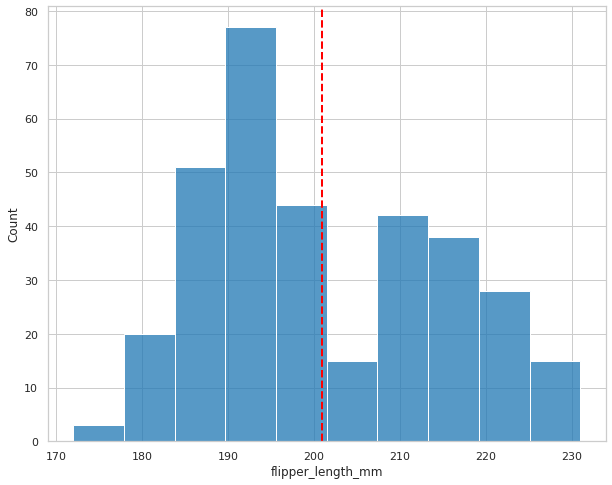

In [58]:
# histograma de la longitud de las aletas
sns.histplot(
    data=preprocess_penguins_df,
    x='flipper_length_mm'
)

#media en la grafica
plt.axvline(
    x=preprocess_penguins_df.flipper_length_mm.mean(),
    color='red',
    linestyle='dashed',
    linewidth=2
)
plt.show()

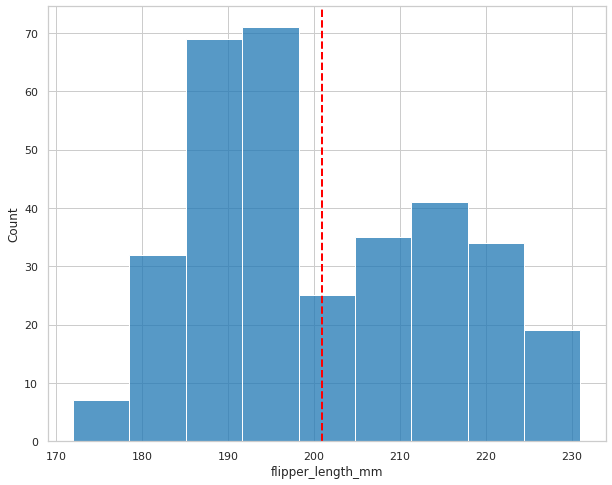

In [59]:
# uso del bins basado en el estimador de Freeman D
sns.histplot(
    data=preprocess_penguins_df,
    x='flipper_length_mm',
    bins='fd'
)

#media en la grafica
plt.axvline(
    x=preprocess_penguins_df.flipper_length_mm.mean(),
    color='red',
    linestyle='dashed',
    linewidth=2
)
plt.show()

plt.show()

In [60]:
#Calculo del Estimador D. Freeman
def freedman_diaconis_bins(x: pd.Series) -> float:
    IQR = x.quantile(0.75) - x.quantile(0.25)
    N = x.size
    return 2 * IQR / N **(1/3)

freedman_diaconis_bins(preprocess_penguins_df)

bill_length_mm         1.312885
bill_depth_mm          0.447246
flipper_length_mm      3.318280
body_mass_g          176.734504
year                   0.288546
dtype: float64

Estimamos que para la longitud de las aletas el ancho del bins es de 3.3

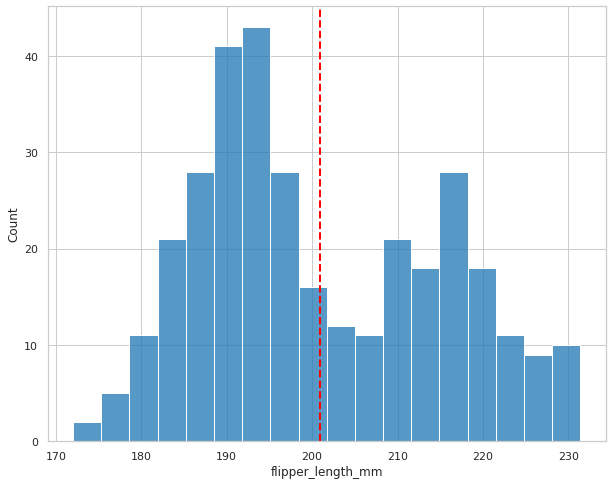

In [61]:
# histogramas de la longitud de las aletas mediante el bins calculado
sns.histplot(
    data=preprocess_penguins_df,
    x='flipper_length_mm',
    binwidth=3.3
)

#media en la grafica
plt.axvline(
    x=preprocess_penguins_df.flipper_length_mm.mean(),
    color='red',
    linestyle='dashed',
    linewidth=2
)
plt.show()

plt.show()

El mejor ajuste se logra con el bin calculado por lo que es mejor siempre realizar el calculo

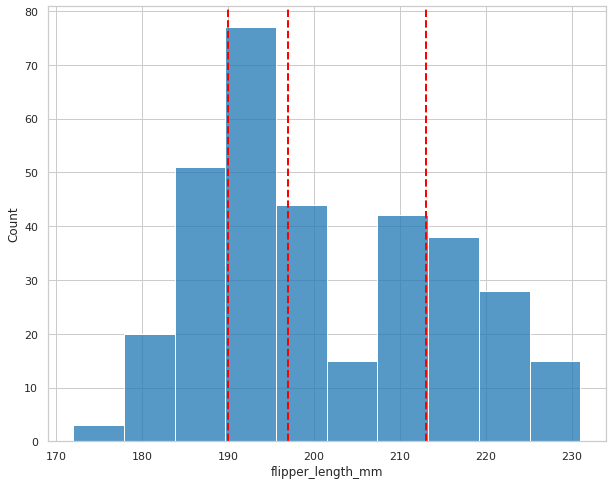

In [62]:
# Rango intercuartilico de la longitud de las aletas sobre el Histograma
sns.histplot(
    data=preprocess_penguins_df,
    x='flipper_length_mm'
)

# Cuantil 25%
plt.axvline(
    x = preprocess_penguins_df.flipper_length_mm.quantile(0.25),
    color = 'red',
    linestyle = 'dashed',
    linewidth = 2
)

# Cuantil 50%
plt.axvline(
    x = preprocess_penguins_df.flipper_length_mm.quantile(0.50),
    color = 'red',
    linestyle = 'dashed',
    linewidth = 2
)

# Cuantil 75%
plt.axvline(
    x = preprocess_penguins_df.flipper_length_mm.quantile(0.75),
    color = 'red',
    linestyle = 'dashed',
    linewidth = 2
)

plt.show()

#### 6.2 Diagrama de Caja

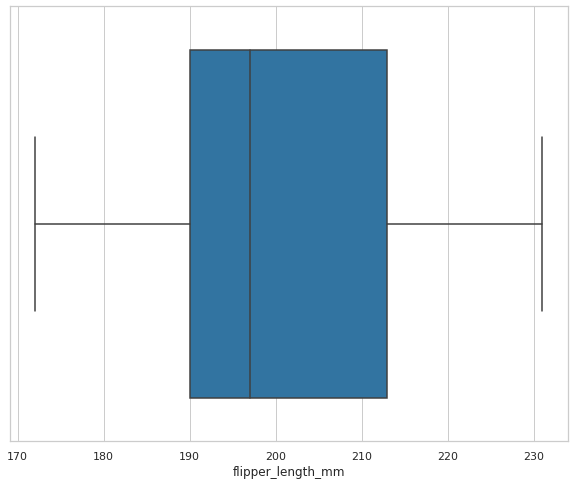

In [63]:
sns.boxplot(
    data=preprocess_penguins_df,
    x='flipper_length_mm'    
)

plt.show()

### 7. Funciones de Probabilidad de Masas (PMFs)

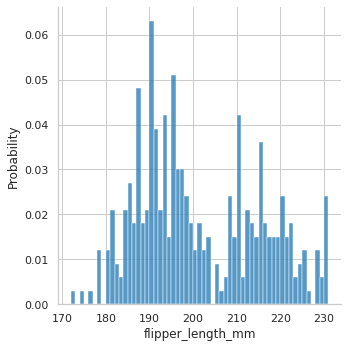

In [64]:
# indica la probabilidad que una variable discreta aleatorio tome un valor determinado

# Grafica de la PMFs de la Longitud de las Aletas con Seaborn
sns.displot(
    data= preprocess_penguins_df,
    x='flipper_length_mm',
    binwidth=1,
    stat='probability' #convierte los conteos en probabilidades
)

plt.show()

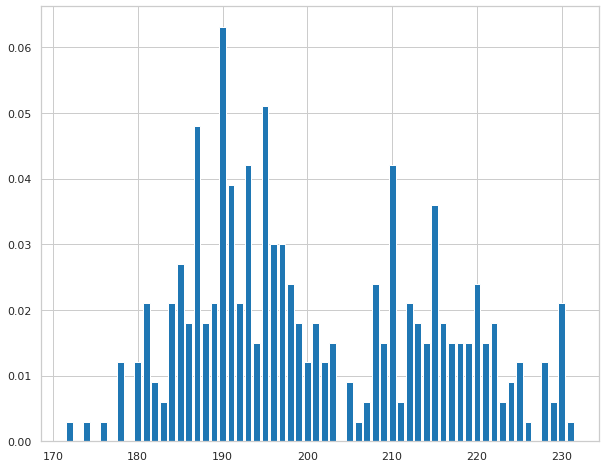

In [65]:
#Tabla de la PMFs de una variable con empiricaldist
pmf_flipper_length_mm = empiricaldist.Pmf.from_seq(
    preprocess_penguins_df.flipper_length_mm,
    normalize = True
)

# Grafica de la PMFs
pmf_flipper_length_mm.bar()

Con empiricaldist las probabilidades son mucho mas precisas que con seaborn

#### 7.2 Calculo de Probabilidad de un valor de Longitud de aletas especifico

In [66]:
# Calcular la probabilidad de encontrar un pinguino con longitud de aletas de 200 mm
pmf_flipper_length_mm(200) 

0.012012012012012012

In [67]:
# Calcular la probabilidad de encontrar un pinguino con longitud de aletas de 185 mm
pmf_flipper_length_mm(185)

0.02702702702702703

In [68]:
# Calcular la probabilidad de encontrar un pinguino con longitud de aletas de 190 mm
pmf_flipper_length_mm(190)

0.06306306306306306

### 8. funciones Empiricas de Probabilidad Acumulada (ECDFs)

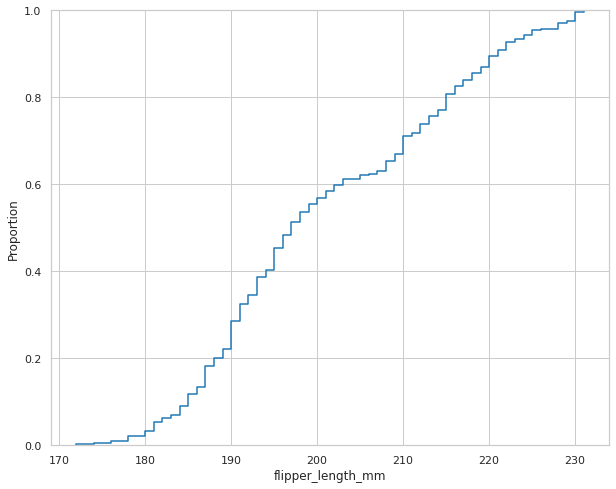

In [69]:
# Devuelve la probabilidad de que una variable sea menor o igual a un valor determinado

# Calculo de ECDFs para la longitud de las aletas con seaborn
sns.ecdfplot(
    data=preprocess_penguins_df,
    x='flipper_length_mm'
)

plt.show()

<AxesSubplot:>

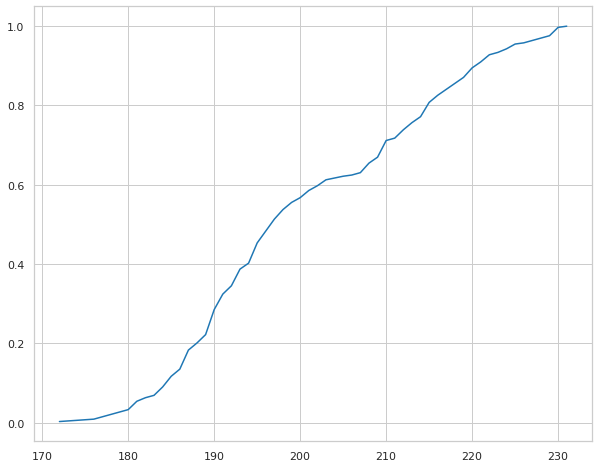

In [70]:
# Calculo de ECDFs de la longitud de las aletas con empiricaldist
cdf_flipper_mm = empiricaldist.Cdf.from_seq(
    preprocess_penguins_df.flipper_length_mm,
    normalize=True
)

#Grafica de la ECDFs
cdf_flipper_mm.plot()

#### 8.2 Calculo de la probabilidad en un rango determinado

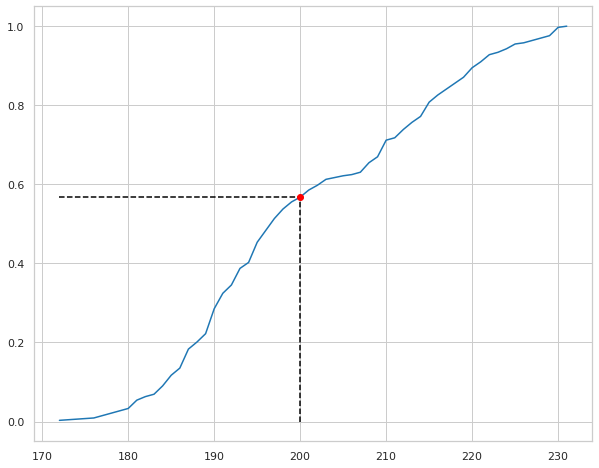

In [71]:
# Probabilidad de encontrar a un pinguino con alas menor o igual a 200 mm
q = 200
p = cdf_flipper_mm.forward(q)

#Grafica de la ECDFs
cdf_flipper_mm.plot()

# Linea vertical en la grafica para denotar q
plt.vlines(
    x=q,
    ymin=0,
    ymax=p,
    color='black',
    linestyles='dashed'
)

# Linea horizontal en la grafica para denotar p
plt.hlines(
    y=p,
    xmin=pmf_flipper_length_mm.qs[0],
    xmax=q,
    color='black',
    linestyles='dashed'
)

plt.plot(q, p, 'ro')
plt.show()

In [73]:
# calculo de la probabilidad anterior de forma numerica
q = 200
p = cdf_flipper_mm.forward(q)
print(q, p)

200 0.5675675675675675


### 8.3 Calculo de la Probabilidad en el Rango IQR

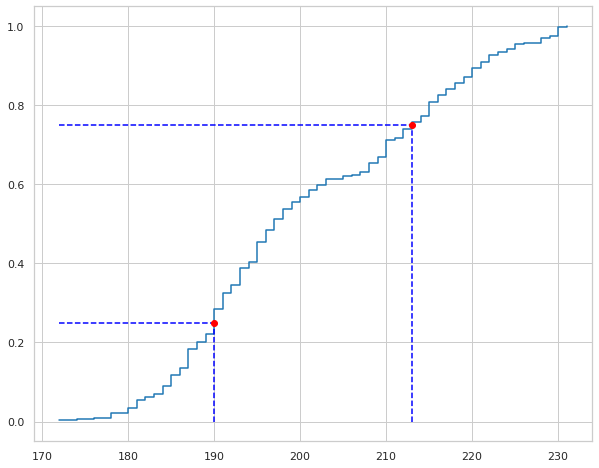

In [75]:
#Calculo de un valor en funcion de una probabilidad dada
cdf_flipper_mm.step()
ps = (0.25, 0.75)   #IQR

qs = cdf_flipper_mm.inverse(ps)     # valores dado un rango de probabilidad

# Grafico de ECDFs
# Lineas verticales
plt.vlines(
    x=qs,
    ymin=0,
    ymax=ps,
    color='blue',
    linestyles='dashed'
)

#Lineas horizontales
plt.hlines(
    y=ps,
    xmin=pmf_flipper_length_mm.qs[0],
    xmax=qs,
    color='blue',
    linestyles='dashed'
)

#Puntos de interseccion
plt.scatter(
    x=qs,
    y=ps,
    color='red',
    zorder = 2
)
plt.show()


### 9. Comparando Distribuciones

Suele hacerse cuando la variable en estudio pertenece a varias categorias. Comparemos la longitud de las alas segun las especies de los pinguinos

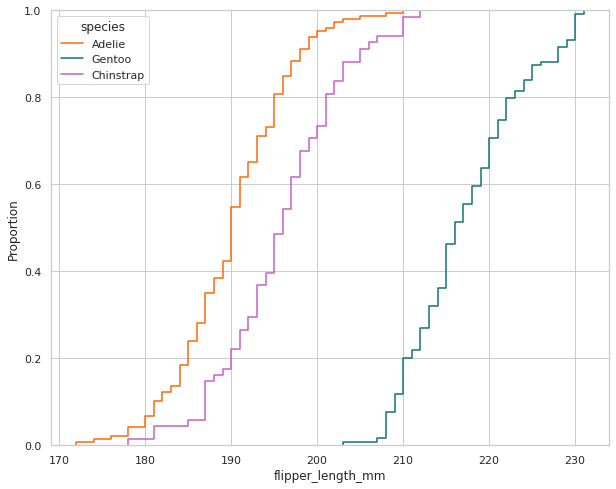

In [77]:
sns.ecdfplot(
    data = preprocess_penguins_df,
    x='flipper_length_mm',
    hue='species',
    palette=penguin_color
)
plt.show()

### 10. Funcion Densidad de Probabilidad (PDFs)

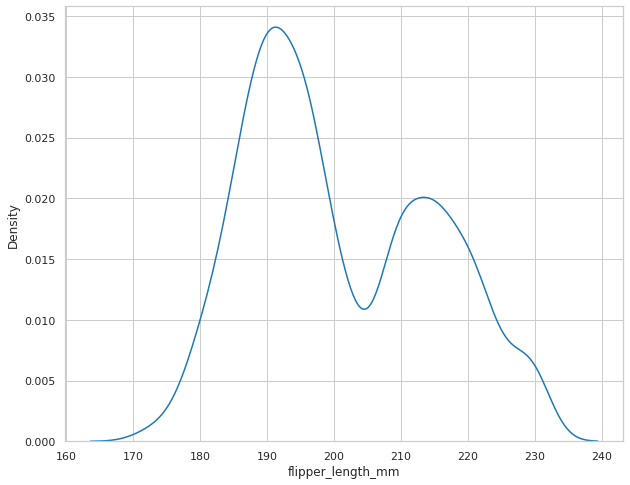

In [82]:
#Ayuda a estimar valores que no contiene el dataset formando una distribucion continua.
#Utilizando la libreria Seaborn
sns.kdeplot(
    data= preprocess_penguins_df,
    x='flipper_length_mm',
    bw_method=0.2   #ancho de banda de suavizado
)
plt.show()

#### 10.2 Comparando la distribucion de los datos con la Teorica utilizando PDFs

In [83]:
# obtenemos los estadisticos de la variable de interes, en este caso para el peso de los pinguinos 
stats = preprocess_penguins_df.body_mass_g.describe()

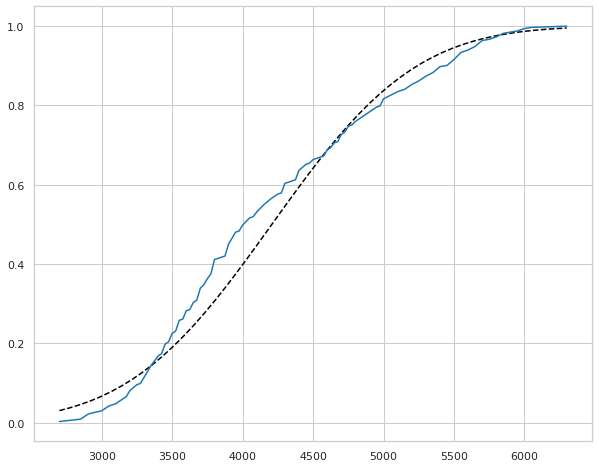

In [86]:
# Calculo de La Distribucion Teorica con ECDFs
# Generamos valores aleatorios con los estadisticos antes obtenidos
# min, max, mean, std
xs = np.linspace(stats['min'], stats['max'])    #array de valores aleatorios
ys = scipy.stats.norm(stats['mean'], stats['std']).cdf(xs)  #probabilidades de cada valor aleatorio

# Grafica de la distribucion Teorica
plt.plot(xs, ys, color='black', linestyle='dashed')

# Grafica de la distribucion de los datos
empiricaldist.Cdf.from_seq(
    preprocess_penguins_df.body_mass_g,
    normalize=True
).plot()

plt.show()

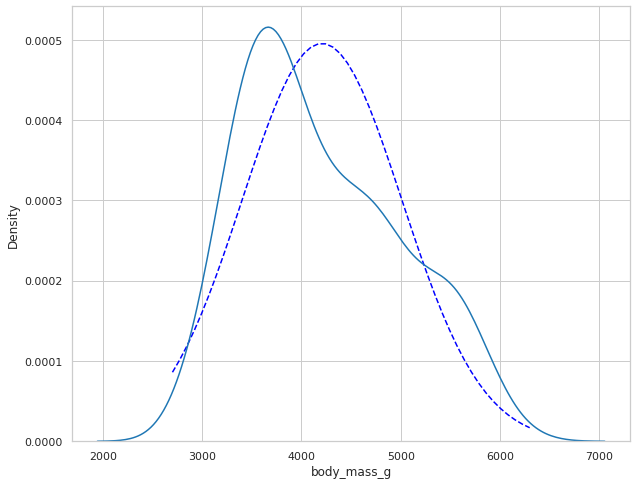

In [87]:
#Calculo de la distribucion teorica con PDFs
xs = np.linspace(stats['min'], stats['max'])    #array de valores aleatorios
ys = scipy.stats.norm(stats['mean'], stats['std']).pdf(xs)  #probabilidades de cada valor aleatorio

#Grafica de la distribucion Teorica
plt.plot(xs, ys, color='blue', linestyle='dashed')

#Grafica de la distribucion de los datos con Seaborn. Empiricaldist no tiene este tipo de dist
sns.kdeplot(data=preprocess_penguins_df, x='body_mass_g')

plt.show()


### 11. Estableciendo Relaciones

#### 11.1 Grafica de Puntos 

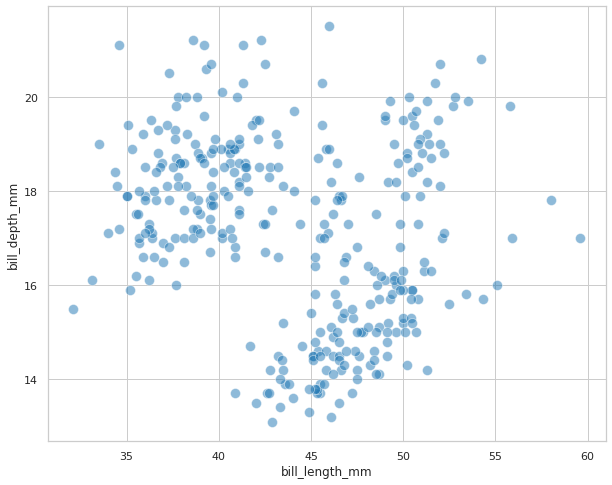

In [91]:
# Grafico de dispersion entre la longitud y el ancho de los picos
sns.scatterplot(
    data= preprocess_penguins_df,
    x='bill_length_mm',
    y='bill_depth_mm',
    alpha=1/2,  #transparencia
    s=100   #tamaño de los puntos
)
plt.show()

#### 11.2 Histograma 2D

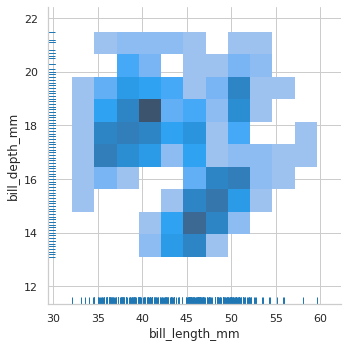

In [92]:
sns.displot(
    data= preprocess_penguins_df,
    x='bill_length_mm',
    y='bill_depth_mm',
    rug=True    #muestra una linea de distribucion para cada variable
)
plt.show()